# Fase 2 – Análisis Exploratorio y Preprocesamiento (EDA)

En esta fase realizamos el análisis exploratorio de datos (EDA) y el preprocesamiento inicial del catálogo KOI ya enriquecido en la Fase 1. El objetivo es entender mejor las distribuciones, valores atípicos, correlaciones y el balance de clases, para decidir qué variables y transformaciones son más adecuadas para el modelado supervisado de la Fase 3 y Fase 4.  

Trabajaremos sobre el archivo `exoplanet_koi_binary_enriched.csv`, que contiene únicamente candidatos con disposición `CONFIRMED` o `FALSE_POSITIVE` y la variable objetivo binaria `is_confirmed`.


# === Librerías base y configuración general ===

En esta sección importamos las librerías principales para el análisis:  
- **pandas / numpy** para manipulación numérica y tabular.  
- **matplotlib / seaborn** para visualización.  
- **scikit-learn** para cálculos estadísticos y futuras transformaciones.  

También fijamos semillas aleatorias y configuramos algunos parámetros estéticos de los gráficos para que los resultados sean reproducibles y visualmente consistentes.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy import stats

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)
pd.set_option("display.max_columns", 100)

print("Versión de pandas:", pd.__version__)

Versión de pandas: 2.2.2


# === Carga del dataset enriquecido desde CSV ===

Aquí cargamos desde disco el archivo `exoplanet_koi_binary_enriched.csv`, generado en la Fase 1.  
Este dataset ya contiene:
- Solo filas con `koi_disposition` en {`CONFIRMED`, `FALSE_POSITIVE`}.  
- La variable objetivo binaria `is_confirmed`.  
- Un subconjunto de variables físicas y derivadas consideradas relevantes para el modelado.


In [ ]:
file_path = "/content/exoplanet_koi_binary_clean.csv"  # si estás en Colab y lo subiste al directorio base

df = pd.read_csv(file_path)

print("Dimensiones del dataset limpio:")
print("Filas (observaciones) :", df.shape[0])
print("Columnas (variables)  :", df.shape[1])

df.head()

Dimensiones del dataset limpio:
Filas (observaciones) : 7585
Columnas (variables)  : 65


,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_time0,koi_eccen,koi_longp,koi_impact,koi_duration,koi_ingress,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,koi_teq,koi_insol,koi_dor,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_bin_oedp_sig,koi_model_dof,koi_model_chisq,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass,koi_sage,ra,dec,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sdec,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky,is_confirmed
0,1.000,0,0,0,0,9.488036,170.538750,2455003.539,0.0,NaN,0.146,2.95750,NaN,615.8,0.022344,3.20796,2.26,0.0853,89.66,793.0,93.59,24.810,0.0,0.0,0.2291,0.4603,5.135849,28.470820,35.8,2,142.0,1.0,0.6864,NaN,NaN,5455.0,4.467,0.14,0.927,0.919,NaN,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.002,19.462294,48.14191,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320,1
1,0.969,0,0,0,0,54.418383,162.513840,2454995.514,0.0,NaN,0.586,4.50700,NaN,874.8,0.027954,3.02368,2.83,0.2734,89.57,443.0,9.11,77.900,0.0,0.0,0.2291,0.4603,7.027669,20.109507,25.8,2,25.0,2.0,0.0023,NaN,NaN,5455.0,4.467,0.14,0.927,0.919,NaN,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.003,19.462265,48.14199,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500,1
2,0.000,0,1,0,0,1.736952,170.307565,2455003.308,0.0,NaN,1.276,2.40641,NaN,8079.2,0.387394,0.22080,33.46,0.0267,67.09,1395.0,891.96,3.278,0.0,0.0,0.2865,0.3556,39.066550,541.895100,505.6,1,621.0,1.0,0.0000,NaN,NaN,5805.0,4.564,-0.52,0.791,0.836,NaN,285.53461,48.285210,15.597,16.100,15.554,15.382,15.266,14.326,13.911,13.809,0.000,19.035638,48.28521,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276,0
3,1.000,0,0,0,0,2.525592,171.595550,2455004.596,0.0,NaN,0.701,1.65450,NaN,603.3,0.024064,1.98635,2.75,0.0374,85.41,1406.0,926.16,8.750,0.0,0.0,0.2844,0.3661,4.749945,33.191900,40.9,1,515.0,1.0,0.3090,NaN,NaN,6031.0,4.438,0.07,1.046,1.095,NaN,288.75488,48.226200,15.509,16.015,15.468,15.292,15.241,14.366,14.064,13.952,0.733,19.250326,48.22626,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070,1
4,1.000,0,0,0,0,11.094321,171.201160,2455004.201,0.0,NaN,0.538,4.59450,NaN,1517.5,0.036779,0.67324,3.90,0.0992,88.11,835.0,114.81,16.360,0.0,0.0,0.2889,0.3511,9.046456,55.204865,66.5,3,95.0,1.0,0.0975,NaN,NaN,6046.0,4.486,-0.08,0.972,1.053,NaN,296.28613,48.224670,15.714,16.234,15.677,15.492,15.441,14.528,14.113,14.132,NaN,19.752406,48.22471,-0.120,0.140,0.00004,NaN,0.040,-0.070,0.080,-0.020,-0.080,0.080,1


# === Descripción general de columnas y tipos ===

En este bloque inspeccionamos la estructura básica del dataset:  
- Número de filas y columnas.  
- Tipos de datos de cada variable (numéricas, booleanas, categóricas).  
- Revisión rápida de nombres de columnas.

El objetivo es confirmar que las columnas clave están presentes y que los tipos de dato son coherentes con el análisis que realizaremos después.


In [ ]:
print("Resumen de tipos de datos:\n")
print(df.dtypes.value_counts())

target_col = "is_confirmed"  # variable objetivo binaria (1=CONFIRMED, 0=FALSE POSITIVE)

# Todas las columnas son numéricas (float/int), pero separamos discretas vs continuas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c != target_col]

discrete_cols = [c for c in feature_cols if df[c].nunique() <= 10]
continuous_cols = [c for c in feature_cols if c not in discrete_cols]

print("\nTotal variables numéricas:", len(numeric_cols))
print("Variables de entrada (X)  :", len(feature_cols))
print("Variable objetivo (y)     :", target_col)

print("\nVariables numéricas DISCRETAS (pocas categorías):")
print(discrete_cols)

print("\nEjemplo de variables numéricas CONTINUAS:")
print(continuous_cols[:15])  # mostramos algunas

Resumen de tipos de datos:

float64    59
int64       6
Name: count, dtype: int64

Total variables numéricas: 65
Variables de entrada (X)  : 64
Variable objetivo (y)     : is_confirmed

Variables numéricas DISCRETAS (pocas categorías):
['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_eccen', 'koi_longp', 'koi_ingress', 'koi_ldm_coeff4', 'koi_ldm_coeff3', 'koi_count', 'koi_tce_plnt_num', 'koi_model_dof', 'koi_model_chisq', 'koi_sage']

Ejemplo de variables numéricas CONTINUAS:
['koi_score', 'koi_period', 'koi_time0bk', 'koi_time0', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_ror', 'koi_srho', 'koi_prad', 'koi_sma', 'koi_incl', 'koi_teq', 'koi_insol', 'koi_dor']


# === Estadísticas globales de variables numéricas ===

Calculamos estadísticas descriptivas (mínimo, máximo, media, desviación estándar, cuartiles) para las variables numéricas.  
Con esto obtenemos una primera idea de:
- Rangos típicos de cada magnitud física.  
- Presencia de valores extremos muy grandes o muy pequeños.  
- Posibles distribuciones muy sesgadas que podrían requerir transformaciones.


In [ ]:
desc_global = df[feature_cols].describe().T
desc_global[["mean", "std", "min", "25%", "50%", "75%", "max"]].head(15)

,mean,std,min,25%,50%,75%,max
koi_score,4.152394e-01,0.478961,0.000000e+00,0.000000e+00,0.000000e+00,9.990000e-01,1.000000e+00
koi_fpflag_nt,2.628873e-01,5.351931,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.650000e+02
koi_fpflag_ss,2.932103e-01,0.455264,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
koi_fpflag_co,2.490442e-01,0.432488,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
koi_fpflag_ec,1.513514e-01,0.358415,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
koi_period,5.166097e+01,111.838381,2.418425e-01,2.243041e+00,8.073941e+00,3.055290e+01,1.071233e+03
koi_time0bk,1.624223e+02,62.899902,1.205159e+02,1.325543e+02,1.364207e+02,1.699312e+02,1.472522e+03
koi_time0,2.454995e+06,62.899902,2.454954e+06,2.454966e+06,2.454969e+06,2.455003e+06,2.456306e+06
koi_eccen,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
koi_longp,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# === Estadísticas por clase (Confirmed vs False Positive) ===

En esta sección comparamos estadísticas descriptivas separando los datos por la etiqueta `is_confirmed`.  
Esto nos permite ver si:
- Algunas variables cambian claramente de media o mediana entre exoplanetas confirmados y falsos positivos.  
- Existen patrones físicos distintos entre ambas clases que puedan ser aprovechados por los modelos supervisados.


In [ ]:
group_means = df.groupby(target_col)[feature_cols].mean().T
group_means.head(15)

is_confirmed,0,1
koi_score,3.810466e-02,9.605577e-01
koi_fpflag_nt,3.153544e-01,1.704297e-01
koi_fpflag_ss,4.567059e-01,5.098325e-03
koi_fpflag_co,3.903699e-01,0.000000e+00
koi_fpflag_ec,2.372391e-01,0.000000e+00
koi_period,6.513893e+01,2.791011e+01
koi_time0bk,1.654395e+02,1.571053e+02
koi_time0,2.454998e+06,2.454990e+06
koi_eccen,0.000000e+00,0.000000e+00
koi_longp,NaN,NaN


# === Valores faltantes por columna ===

Aquí cuantificamos el porcentaje de valores faltantes por variable.  
Esta información es clave para decidir:
- Qué columnas pueden conservarse (pocos faltantes, se pueden imputar).  
- Qué columnas conviene descartar (demasiados faltantes o poco valor informativo).  

Estas decisiones impactan directamente en la robustez del modelo.


In [ ]:
missing_count = df.isnull().sum()
missing_pct = df.isnull().mean() * 100

missing_summary = (
    pd.DataFrame({
        "missing_count": missing_count,
        "missing_pct": missing_pct
    })
    .sort_values(by="missing_pct", ascending=False)
)

print("Top 15 variables con mayor porcentaje de NaN:")
missing_summary.head(15)

Top 15 variables con mayor porcentaje de NaN:


,missing_count,missing_pct
koi_ingress,7585,100.000000
koi_sage,7585,100.000000
koi_longp,7585,100.000000
koi_model_chisq,7585,100.000000
koi_model_dof,7585,100.000000
koi_fwm_stat_sig,962,12.682927
koi_score,910,11.997363
koi_bin_oedp_sig,910,11.997363
koi_fwm_prao,746,9.835201
koi_fwm_pdeco,718,9.466051


# === Detección simple de outliers en variables clave ===

En este bloque realizamos una detección preliminar de valores atípicos utilizando, por ejemplo, reglas basadas en desviaciones estándar o IQR.  
El objetivo no es eliminar automáticamente los outliers, sino:
- Identificar magnitudes con valores muy extremos.  
- Valorar si se trata de fenómenos físicos plausibles o de posibles errores/mediciones anómalas.


In [ ]:
key_vars = ["koi_prad", "koi_period", "koi_teq", "koi_steff"]

for var in key_vars:
    if var in df.columns:
        data = df[var].dropna()
        z_scores = np.abs(stats.zscore(data))
        outliers = (z_scores > 3).sum()
        print(f"{var}: {outliers} outliers (|z| > 3) de {len(data)} valores válidos.")
    else:
        print(f"{var}: NO está en el dataframe.")

koi_prad: 8 outliers (|z| > 3) de 7326 valores válidos.
koi_period: 232 outliers (|z| > 3) de 7585 valores válidos.
koi_teq: 103 outliers (|z| > 3) de 7326 valores válidos.
koi_steff: 100 outliers (|z| > 3) de 7326 valores válidos.


# === Boxplots de distribuciones para algunas variables ===

Mostramos **boxplots** de variables físicas importantes (por ejemplo, periodo orbital, radio del planeta, profundidad del tránsito).  
Los boxplots permiten:
- Visualizar la dispersión y la mediana.  
- Detectar valores atípicos de forma visual.  
- Comparar de forma rápida la escala de distintas variables.


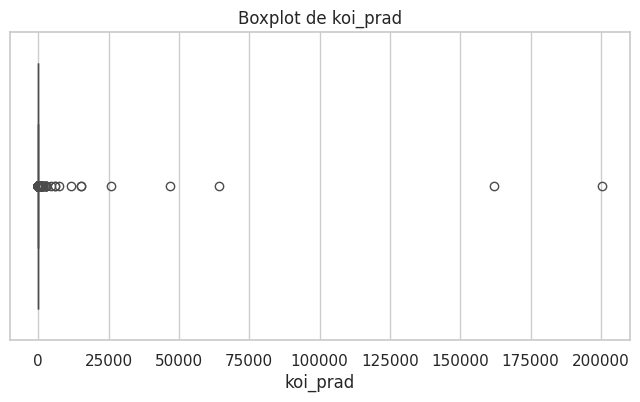

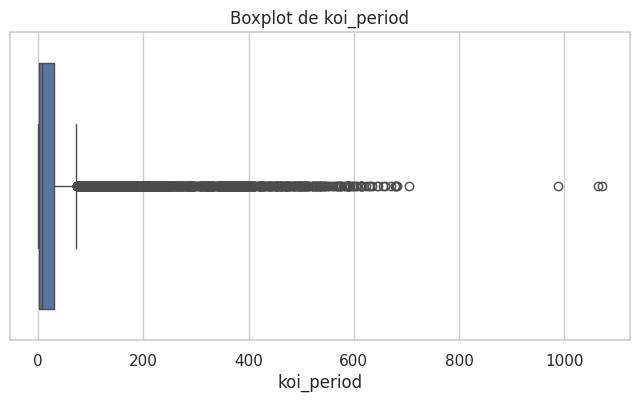

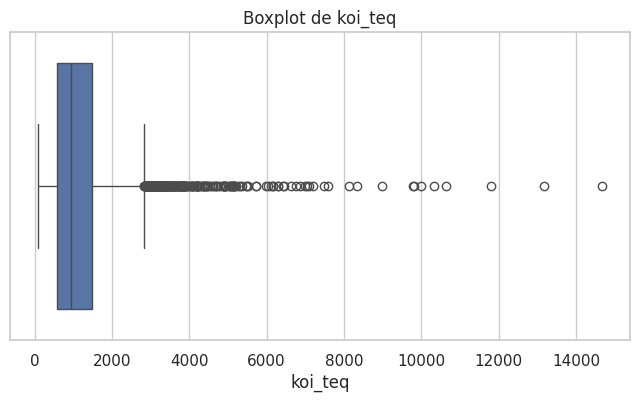

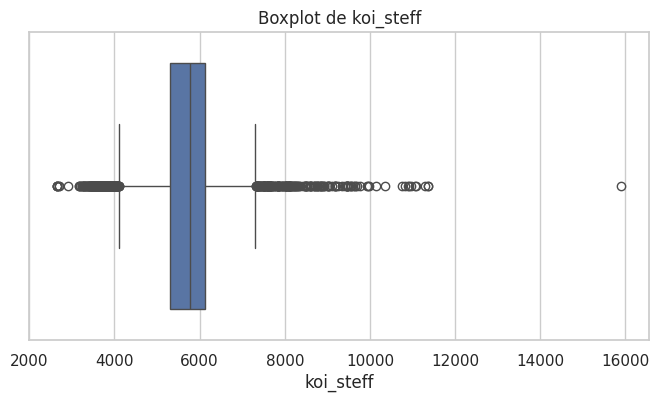

In [ ]:
for var in key_vars:
    if var in df.columns:
        plt.figure()
        sns.boxplot(x=df[var])
        plt.title(f"Boxplot de {var}")
        plt.show()

# === Histogramas de variables clave separados por clase ===

En esta sección graficamos histogramas para variables clave, diferenciando por clase (`is_confirmed = 0` vs `1`).  
Con esto observamos:
- Si la forma de la distribución cambia entre exoplanetas confirmados y falsos positivos.  
- En qué rangos de valores se concentran cada una de las clases, lo que ayuda a interpretar después las decisiones de los modelos.


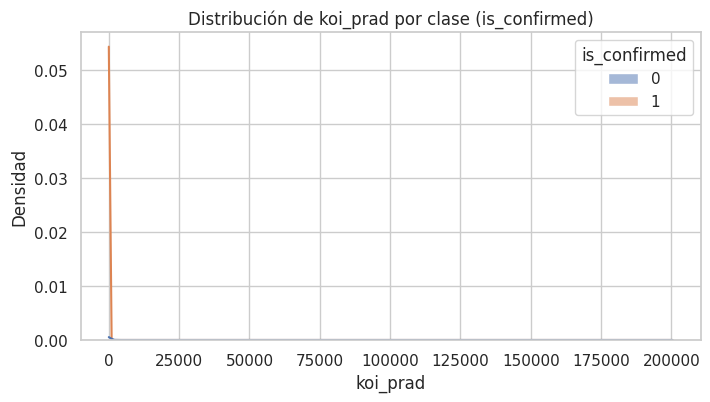

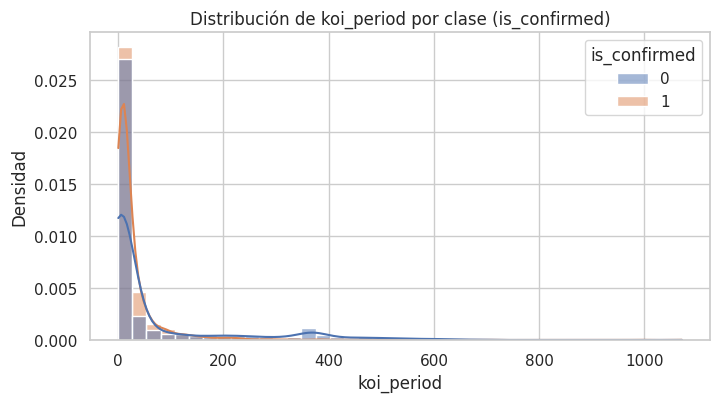

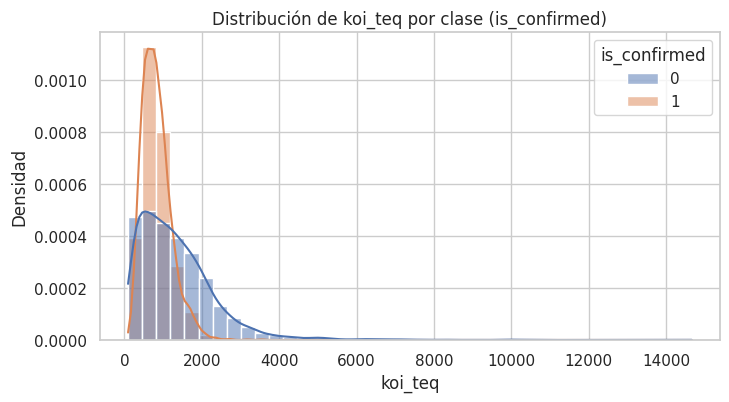

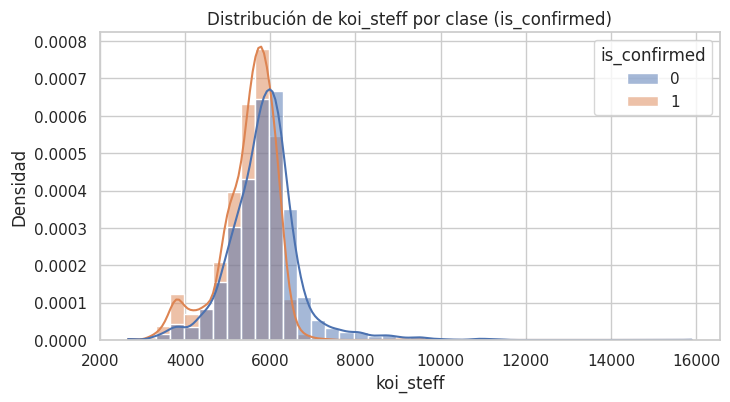

In [ ]:
for var in key_vars:
    if var in df.columns:
        plt.figure()
        sns.histplot(
            data=df,
            x=var,
            hue=target_col,
            kde=True,
            stat="density",
            common_norm=False,
            bins=40
        )
        plt.title(f"Distribución de {var} por clase (is_confirmed)")
        plt.xlabel(var)
        plt.ylabel("Densidad")
        plt.show()

# === Dispersión koi_prad vs koi_period (log-log) ===

Generamos un gráfico de dispersión entre el radio planetario (`koi_prad`) y el periodo orbital (`koi_period`) en escala log-log.  
Este tipo de gráfica permite:
- Visualizar poblaciones de planetas en diferentes rangos de tamaño y periodo.  
- Identificar posibles regiones del espacio de parámetros donde se concentran más exoplanetas confirmados o falsos positivos.


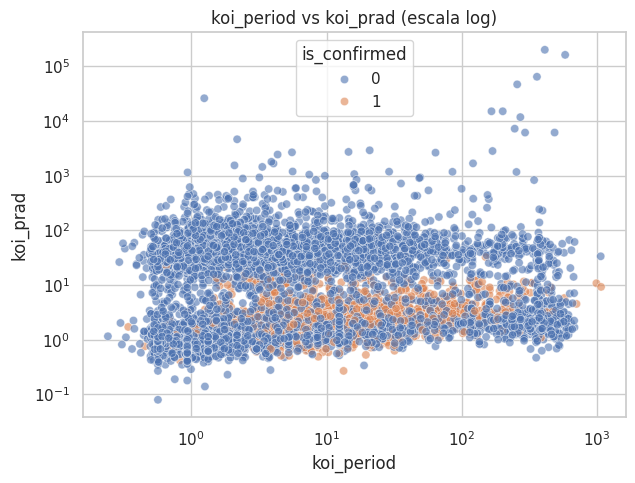

In [ ]:
if ("koi_period" in df.columns) and ("koi_prad" in df.columns):
    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        data=df,
        x="koi_period",
        y="koi_prad",
        hue=target_col,
        alpha=0.6
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.title("koi_period vs koi_prad (escala log)")
    plt.show()

# === Dispersión koi_teq vs koi_insol (log-log) ===

Aquí analizamos la relación entre la temperatura de equilibrio del planeta (`koi_teq`) y la insolación (`koi_insol`) en escala log-log.  
El objetivo es:
- Observar cómo se distribuyen los candidatos en función de la energía que reciben de su estrella.  
- Detectar si las clases tienden a separar o mezclarse en este espacio físico.


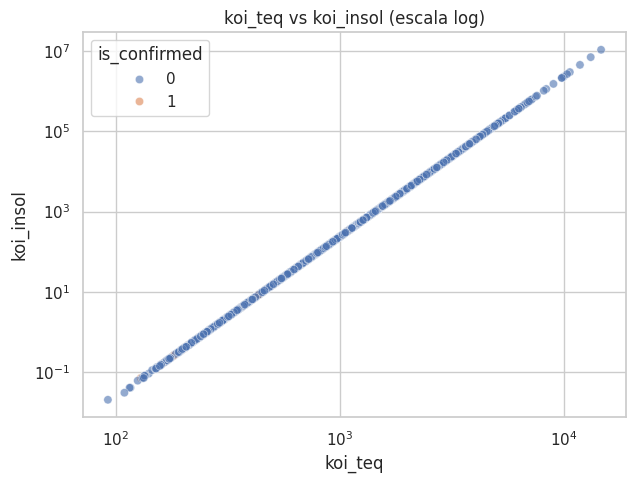

In [ ]:
if ("koi_teq" in df.columns) and ("koi_insol" in df.columns):
    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        data=df,
        x="koi_teq",
        y="koi_insol",
        hue=target_col,
        alpha=0.6
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.title("koi_teq vs koi_insol (escala log)")
    plt.show()

# === Matriz de correlación de un subconjunto físico de variables ===

Calculamos una **matriz de correlación** para un conjunto de variables físicas seleccionadas (periodo, radio, profundidad de tránsito, propiedades estelares, etc.).  
La matriz, visualizada como mapa de calor, ayuda a:
- Detectar pares de variables fuertemente correlacionadas (posible redundancia).  
- Identificar grupos de variables que describen fenómenos similares o relacionados.


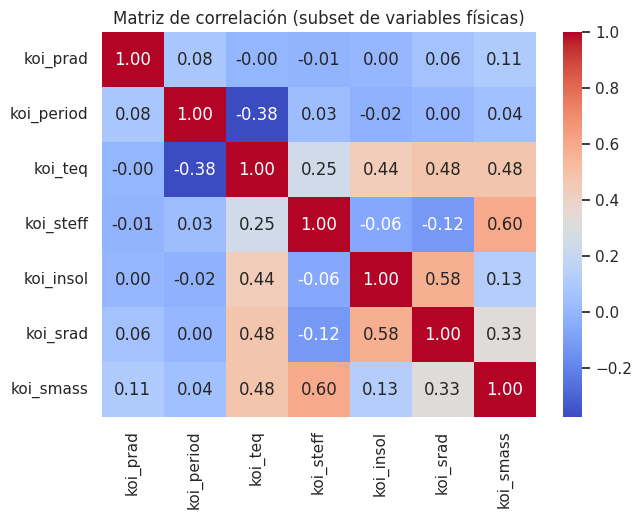

In [ ]:
subset_vars = ["koi_prad", "koi_period", "koi_teq", "koi_steff",
               "koi_insol", "koi_srad", "koi_smass"]
subset_vars = [v for v in subset_vars if v in df.columns]

corr_subset = df[subset_vars].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(corr_subset, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación (subset de variables físicas)")
plt.show()

# === Correlación de cada variable con la etiqueta is_confirmed ===

En esta parte medimos la correlación de cada variable numérica con la etiqueta binaria `is_confirmed`.  
Aunque la correlación lineal no captura todas las relaciones posibles, sirve para:
- Priorizar variables que muestran mayor asociación con la clase.  
- Tener una primera pista de qué magnitudes podrían ser más influyentes en los modelos supervisados.


In [ ]:
corr_target = (
    df.corr()[target_col]
    .sort_values(ascending=False)
)

print("Correlación de cada variable con is_confirmed (top 20):")
corr_target.head(20)

Correlación de cada variable con is_confirmed (top 20):


,is_confirmed
is_confirmed,1.000000
koi_score,0.946904
koi_count,0.483595
koi_smet,0.329389
koi_incl,0.314229
koi_fwm_stat_sig,0.277633
koi_tce_plnt_num,0.251768
koi_ldm_coeff1,0.221847
koi_bin_oedp_sig,0.184122
koi_slogg,0.182247


# === Preparación del conjunto de modelado: selección de columnas ===

Tras el EDA, definimos el subconjunto de columnas que utilizaremos en el modelado.  
En este paso:
- Eliminamos columnas con demasiados valores faltantes o poco interpretables.  
- Mantenemos variables físicas relevantes y derivadas que han mostrado potencial discriminativo.  

El resultado es un dataset más compacto y manejable para las fases de modelado.


Conteo de clases (0 = FALSE POSITIVE, 1 = CONFIRMED):
is_confirmed
0    4839
1    2746
Name: count, dtype: int64

Porcentaje de clases:
is_confirmed
0    63.796968
1    36.203032
Name: proportion, dtype: float64


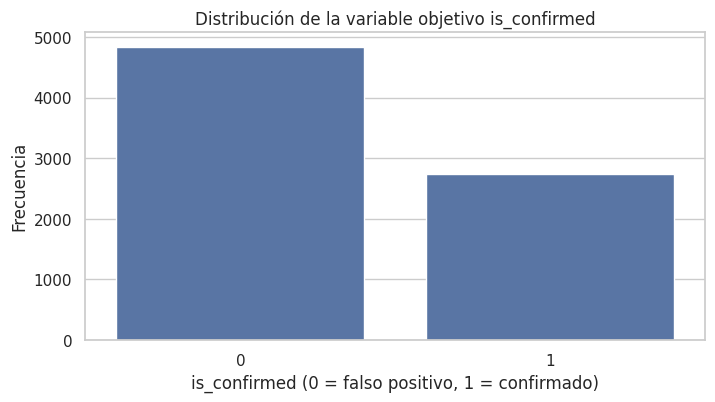

In [ ]:
class_counts = df[target_col].value_counts()
class_pct = df[target_col].value_counts(normalize=True) * 100

print("Conteo de clases (0 = FALSE POSITIVE, 1 = CONFIRMED):")
print(class_counts)
print("\nPorcentaje de clases:")
print(class_pct)

plt.figure()
sns.countplot(x=df[target_col])
plt.title("Distribución de la variable objetivo is_confirmed")
plt.xlabel("is_confirmed (0 = falso positivo, 1 = confirmado)")
plt.ylabel("Frecuencia")
plt.show()

# === Definir X (características) e y (etiqueta) ===

Aquí separamos explícitamente:
- `X`: matriz de características (todas las variables predictoras seleccionadas).  
- `y`: vector objetivo (`is_confirmed`).  

Esta estructura es la que espera scikit-learn para entrenar modelos supervisados.


In [ ]:
# 1) Eliminar columnas con >= 95% de NaN
missing_pct = df.isnull().mean() * 100
high_missing_cols = missing_pct[missing_pct >= 95].index.tolist()

print("Columnas con >=95% NaN que se eliminarán:")
print(high_missing_cols)

df1 = df.drop(columns=high_missing_cols).copy()

# 2) Eliminar columnas constantes (sin variación)
numeric_cols1 = df1.select_dtypes(include=[np.number]).columns.tolist()
feature_cols1 = [c for c in numeric_cols1 if c != target_col]

constant_cols = [c for c in feature_cols1 if df1[c].nunique() <= 1]

print("\nColumnas constantes que se eliminarán:")
print(constant_cols)

df2 = df1.drop(columns=constant_cols).copy()

# 3) Eliminar una de cada par de variables muy correlacionadas (>|0.95|)
numeric_cols2 = df2.select_dtypes(include=[np.number]).columns.tolist()
feature_cols2 = [c for c in numeric_cols2 if c != target_col]

corr_matrix = df2[feature_cols2].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

corr_threshold = 0.95
to_drop_corr = [column for column in upper.columns if any(upper[column] > corr_threshold)]

print("\nColumnas a eliminar por correlación > 0.95:")
print(to_drop_corr)

df_model = df2.drop(columns=to_drop_corr).copy()

print("\nDimensiones finales del dataset de modelado:")
print(df_model.shape)

Columnas con >=95% NaN que se eliminarán:
['koi_longp', 'koi_ingress', 'koi_model_dof', 'koi_model_chisq', 'koi_sage']

Columnas constantes que se eliminarán:
['koi_eccen', 'koi_ldm_coeff4', 'koi_ldm_coeff3']

Columnas a eliminar por correlación > 0.95:
['koi_time0', 'koi_ror', 'koi_sma', 'koi_ldm_coeff1', 'koi_gmag', 'koi_rmag', 'koi_imag', 'koi_zmag', 'koi_jmag', 'koi_hmag', 'koi_kmag', 'koi_fwm_sra', 'koi_fwm_sdec']

Dimensiones finales del dataset de modelado:
(7585, 44)


# === Resumen de tamaños antes de la partición ===

Mostramos el número total de instancias y verificamos que no existan inconsistencias entre `X` e `y`.  
Este chequeo es importante antes de dividir en train/validation/test, para detectar posibles errores de filtrado o indexado.


In [ ]:
numeric_cols_final = df_model.select_dtypes(include=[np.number]).columns.tolist()
feature_cols_final = [c for c in numeric_cols_final if c != target_col]

X = df_model[feature_cols_final]
y = df_model[target_col]

print("Número de variables de entrada (X):", X.shape[1])
print("Número de observaciones:", X.shape[0])

print("\nNaN totales en X:", X.isnull().sum().sum())
print("NaN en y:", y.isnull().sum())

Número de variables de entrada (X): 43
Número de observaciones: 7585

NaN totales en X: 14162
NaN en y: 0


# === División estratificada en Train / Validation / Test ===

En este bloque realizamos la partición estratificada del dataset en:
- **Train**: ~70 % de los datos.  
- **Validation**: ~15 %.  
- **Test**: ~15 %.  

La estratificación garantiza que la proporción de exoplanetas confirmados y falsos positivos se mantenga similar en cada subconjunto, lo que hace la evaluación más justa y estable.


In [ ]:
# Primero: Train+Val (85%) y Test (15%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.15,
    stratify=y,
    random_state=42
)

# Segundo: de Train+Val sacamos Train (70%) y Val (15%)
# 0.1765 ≈ 0.15 / 0.85

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.1765,
    stratify=y_trainval,
    random_state=42
)

print("X_train:", X_train.shape)
print("X_val  :", X_val.shape)
print("X_test :", X_test.shape)

print("\nProporción de clases en cada conjunto:")
for name, labels in zip(["Train", "Val", "Test"], [y_train, y_val, y_test]):
    print(f"{name}:")
    print(labels.value_counts(normalize=True))
    print("-" * 30)

X_train: (5309, 43)
X_val  : (1138, 43)
X_test : (1138, 43)

Proporción de clases en cada conjunto:
Train:
is_confirmed
0    0.637973
1    0.362027
Name: proportion, dtype: float64
------------------------------
Val:
is_confirmed
0    0.637961
1    0.362039
Name: proportion, dtype: float64
------------------------------
Test:
is_confirmed
0    0.637961
1    0.362039
Name: proportion, dtype: float64
------------------------------


# === Estandarización de características numéricas y guardado de escaladores ===

Para los algoritmos sensibles a la escala (regresión logística, SVM, KNN y MLP) aplicamos estandarización (media 0, desviación estándar 1) sobre las características numéricas.  

Además, guardamos el objeto de escalado (por ejemplo, `StandardScaler`) para:
- Asegurar que el mismo esquema de transformación pueda aplicarse en la Fase 4/Fase 5.  
- Mantener la consistencia entre los datos de entrenamiento y los nuevos datos que se quieran clasificar en el futuro.


In [ ]:
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

# 1. Imputación usando solo información del conjunto de entrenamiento
X_train_imp = imputer.fit_transform(X_train)
X_val_imp   = imputer.transform(X_val)
X_test_imp  = imputer.transform(X_test)

# 2. Escalado
X_train_scaled = scaler.fit_transform(X_train_imp)
X_val_scaled   = scaler.transform(X_val_imp)
X_test_scaled  = scaler.transform(X_test_imp)

# Volvemos a DataFrame para facilitar interpretación
feature_names = feature_cols_final

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
X_val_scaled_df   = pd.DataFrame(X_val_scaled,   columns=feature_names, index=X_val.index)
X_test_scaled_df  = pd.DataFrame(X_test_scaled,  columns=feature_names, index=X_test.index)

print("Formas después de imputar y escalar:")
print("X_train_scaled:", X_train_scaled_df.shape)
print("X_val_scaled  :", X_val_scaled_df.shape)
print("X_test_scaled :", X_test_scaled_df.shape)

print("\nNaN en X_train_scaled:", np.isnan(X_train_scaled_df.values).sum())

Formas después de imputar y escalar:
X_train_scaled: (5309, 43)
X_val_scaled  : (1138, 43)
X_test_scaled : (1138, 43)

NaN en X_train_scaled: 0


# === Conclusiones de la Fase 2 (EDA y Preprocesamiento) ===

En esta fase hemos:
- Cargado el dataset KOI enriquecido y verificado su estructura básica.  
- Analizado distribuciones, outliers, correlaciones y balance de clases para las variables físicas más importantes.  
- Seleccionado un subconjunto de variables relevantes para el modelado, reduciendo ruido y redundancia.  
- Definido la partición estratificada en **train**, **validation** y **test**, y aplicado estandarización a las características numéricas.

Con esto dejamos preparado un conjunto de datos limpio y estructurado que servirá como entrada directa para los modelos supervisados de la Fase 3 y Fase 4.


In [ ]:
print("===== RESUMEN FASE 2 =====")
print(f"Dataset de modelado final: {df_model.shape[0]} filas, {df_model.shape[1]} columnas")
print(f"Variables de entrada X: {len(feature_cols_final)}")
print(f"Variable objetivo y: {target_col}")

print("\nConjuntos:")
print("Train:", X_train.shape[0], "ejemplos")
print("Val  :", X_val.shape[0],   "ejemplos")
print("Test :", X_test.shape[0],  "ejemplos")

===== RESUMEN FASE 2 =====
Dataset de modelado final: 7585 filas, 44 columnas
Variables de entrada X: 43
Variable objetivo y: is_confirmed

Conjuntos:
Train: 5309 ejemplos
Val  : 1138 ejemplos
Test : 1138 ejemplos


# === Guardar dataset de modelado para fases posteriores ===

Finalmente, exportamos a disco las versiones procesadas del dataset (incluyendo las particiones y/o el dataset completo preparado).  
Este paso permite:
- Reutilizar exactamente los mismos datos en las fases de modelado.  
- Evitar repetir todo el EDA y preprocesamiento cada vez que queramos entrenar o ajustar un modelo.


In [ ]:
output_file = "/content/exoplanet_koi_binary_clean_eda.csv"

# df_model es el DataFrame ya limpio (44 columnas)
df_model.to_csv(output_file, index=False)

print("Dataset de modelado guardado como:", output_file)
print("Dimensiones de df_model:", df_model.shape)
print("Número de columnas:", df_model.shape[1])

Dataset de modelado guardado como: /content/exoplanet_koi_binary_clean_eda.csv
Dimensiones de df_model: (7585, 44)
Número de columnas: 44
